# Deepfakes make me feel [cagey](https://imgur.com/zzsW0Zf).
![Deepfakes make me feel cagey](https://i.imgur.com/zzsW0Zf.gif)

This kernel is supposed to give an introduction to deepfakes and detectors. check out some of the data and point out some general challenge things.

Who would be better at introducing this than Károly from [Two Minute Papers](https://www.youtube.com/watch?v=RoGHVI-w9bE), so hold on to your papers. 

(It is a video about a SOTA video of FaceForensics++ after all)

In [1]:
from IPython.lib.display import YouTubeVideo
karol = YouTubeVideo('RoGHVI-w9bE', width=560, height=315)
display(karol)

Deepfakes are fakes generated by deep learning. So far so easy. 

# How are Deep Fakes Generated?

This usually means someone used a generative model like an Auto - Encoder or most likely a Generative Adversarial Network, short GAN. GANs are technically two networks that work against each other, illustrated below. The artist (generator) draws its inspiration from a noise sample and creates a rendering of the data you are trying to generate with said GAN. The private investigator (discriminator) randomly gets assigned real and fake data to investigate. 

The learning process is collaborative. The generator gets better at fooling the discriminator and the discriminator gets better at figuring out which data is real and which isn't. In mathematical terms they are learning until a [Nash equilibrium](https://en.wikipedia.org/wiki/Nash_equilibrium) is reached, which means neither can learn new tricks and get better. They're a really cool concept and even used in scientific simulation at [CERN](https://indico.cern.ch/event/595059/contributions/2497383/attachments/1431666/2199445/gan_presentation_IML.pdf).

You can probably guess that they can be tricky to train, due to so many moving parts. This has become a very popular area of research, warranting a [GAN Zoo](https://github.com/hindupuravinash/the-gan-zoo) of all named GANs. Some important stuff you may want to check out if your interested are keywords like Wasserstein GANs, Gradient Penalization, Attention, and in this context Style Transfer (namely face2face). Maybe you'll even find some in the comments.


![GAN from Dramsch PhD thesis.](https://dramsch.net/assets/images/GAN.PNG)
Figure describing Generative Adversarial Networks from my [PhD thesis](https://orbit.dtu.dk/en/publications/machine-learning-in-4d-seismic-data-analysis-deep-neural-networks).

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import cv2
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline

from pathlib import Path

from sklearn_pandas import DataFrameMapper
import sklearn, sklearn.preprocessing
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_score

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# Any results you write to the current directory are saved as output.

# Handling Video
Since we're dealing with video here, let's have a quick look at the data.

Just keep in mind that the data is so large that you'll want to use a generator to concurrently load data for training. In PyTorch they're called Dataset and Dataloader and the only one I found is [here](https://github.com/MohsenFayyaz89/PyTorch_Video_Dataset). In keras it's the custom ImageGenerator, where you'll have to subclass [Sequence](https://keras.io/utils/), I found a good starter [here](https://github.com/jphdotam/keras_generator_example), which unfortunately expects numpy files. However, you may be able to change it to mp4 using OpenCV.

So let's have a quick look at OpenCV, also check out their tutorial on [loading video data](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_gui/py_video_display/py_video_display.html). The documentation for [VideoCapture.get()](https://docs.opencv.org/2.4/modules/highgui/doc/reading_and_writing_images_and_video.html#videocapture-get) is a bit dense, but let's try some stuff.

0.     CV_CAP_PROP_POS_MSEC Current position of the video file in milliseconds or video capture timestamp.
1.     CV_CAP_PROP_POS_FRAMES 0-based index of the frame to be decoded/captured next.
2.     CV_CAP_PROP_POS_AVI_RATIO Relative position of the video file: 0 - start of the film, 1 - end of the film.
3.     CV_CAP_PROP_FRAME_WIDTH Width of the frames in the video stream.
4.     CV_CAP_PROP_FRAME_HEIGHT Height of the frames in the video stream.
5.     CV_CAP_PROP_FPS Frame rate.
6.     CV_CAP_PROP_FOURCC 4-character code of codec.
7.     CV_CAP_PROP_FRAME_COUNT Number of frames in the video file.
8.     CV_CAP_PROP_FORMAT Format of the Mat objects returned by retrieve() .
9.     CV_CAP_PROP_MODE Backend-specific value indicating the current capture mode.
1.     CV_CAP_PROP_BRIGHTNESS Brightness of the image (only for cameras).
1.     CV_CAP_PROP_CONTRAST Contrast of the image (only for cameras).
1.     CV_CAP_PROP_SATURATION Saturation of the image (only for cameras).
1.     CV_CAP_PROP_HUE Hue of the image (only for cameras).
1.     CV_CAP_PROP_GAIN Gain of the image (only for cameras).
1.     CV_CAP_PROP_EXPOSURE Exposure (only for cameras).
16.     CV_CAP_PROP_CONVERT_RGB Boolean flags indicating whether images should be converted to RGB.
17.     CV_CAP_PROP_WHITE_BALANCE_U The U value of the whitebalance setting (note: only supported by DC1394 v 2.x backend currently)
18.     CV_CAP_PROP_WHITE_BALANCE_V The V value of the whitebalance setting (note: only supported by DC1394 v 2.x backend currently)
19.     CV_CAP_PROP_RECTIFICATION Rectification flag for stereo cameras (note: only supported by DC1394 v 2.x backend currently)
20.     CV_CAP_PROP_ISO_SPEED The ISO speed of the camera (note: only supported by DC1394 v 2.x backend currently)
21.     CV_CAP_PROP_BUFFERSIZE Amount of frames stored in internal buffer memory (note: only supported by DC1394 v 2.x backend currently)


In [3]:
def vid_stat(vid):
    cap = cv2.VideoCapture(vid)
    width = cap.get(3)
    height = cap.get(4)
    frame_rate = cap.get(5)
    frame_num = cap.get(7)
    #_, frame = cap.read()
    cap.release()

    return vid.rsplit("/")[-1], width, height, frame_rate, frame_num

# Exploratory Data Analysis
Meta-data like a good wine. Are there variations in framerate? Is the length slightly off?

Lots of funny things happen when you try to fake videos (did I mention that GANs are a nuisance to train?)

In [4]:

train = Path("/kaggle/input/deepfake-detection-challenge/train_sample_videos/")
test = Path("/kaggle/input/deepfake-detection-challenge/test_videos/")


train_stats = [vid_stat(str(vid)) for vid in train.glob('*.mp4')]
test_stats = [vid_stat(str(vid)) for vid in test.glob('*.mp4')]

Let's look at a single fake video. Could you tell?

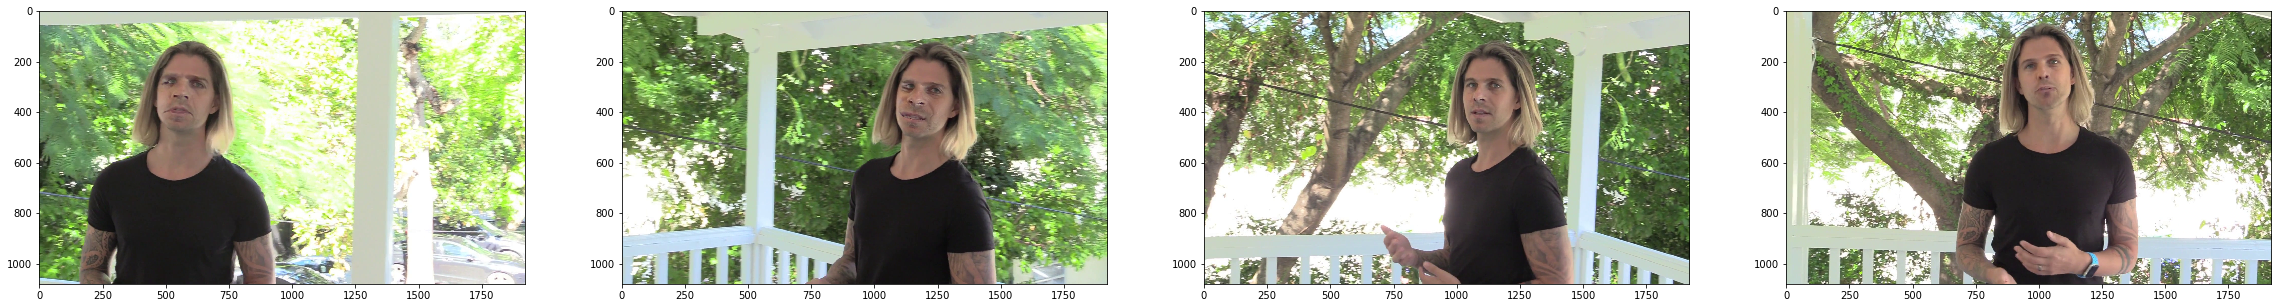

In [5]:
fig,axs = plt.subplots(ncols=4, figsize=(40,10))
vid = '/kaggle/input/deepfake-detection-challenge/train_sample_videos/aagfhgtpmv.mp4'
cap = cv2.VideoCapture(str(vid))
for i in range(4):
    [cap.read() for _ in range(50)]
    _, frame = cap.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    axs[i].imshow(frame)

I picked this video for the visual artifacts. Unfortunately, this competition may fake images or voices. This one looks like it may be a voice swap.

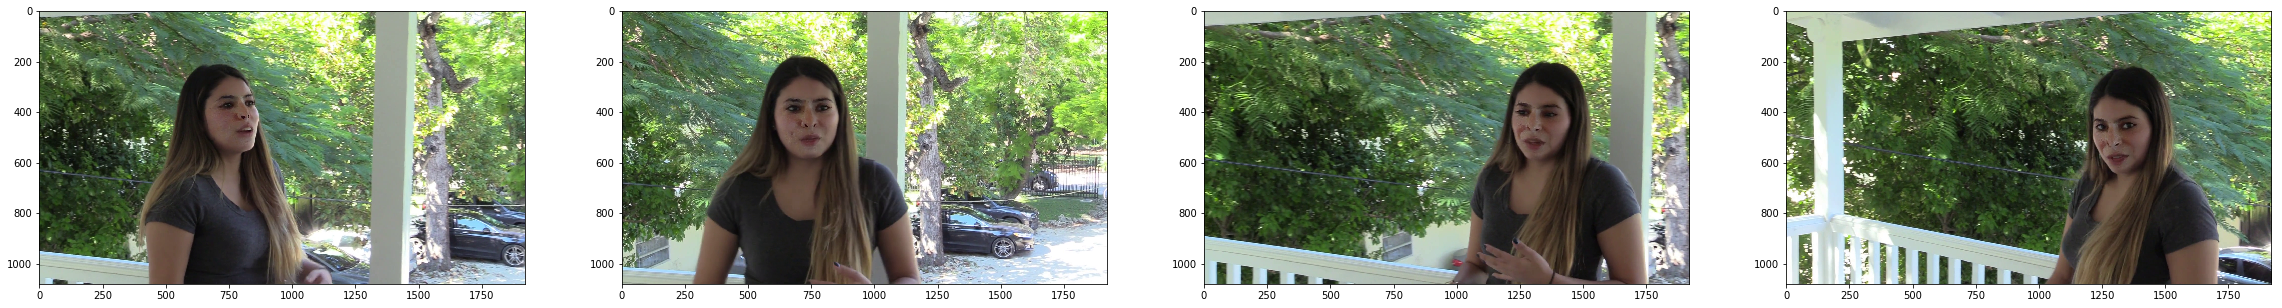

In [6]:
fig,axs = plt.subplots(ncols=4, figsize=(40,10))
vid = '/kaggle/input/deepfake-detection-challenge/train_sample_videos/etohcvnzbj.mp4'
cap = cv2.VideoCapture(str(vid))
for i in range(4):
    [cap.read() for _ in range(50)]
    _, frame = cap.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    axs[i].imshow(frame)

In the deep learniing models, temporal signal will probably be quite important. GANs often cause flickering artifacts, however, recent generative models have become much better at this.

In [7]:
df = pd.DataFrame(train_stats, columns = ['Id', 'Width', 'Height', 'FPS', 'Number Frames'])
df["Length"] = df.FPS * df["Number Frames"]
df["Area"] = df.Width * df.Height
df.set_index('Id', inplace=True)
df.head()

,Width,Height,FPS,Number Frames,Length,Area
Id,,,,,,
bpwzipqtxf.mp4,1920.0,1080.0,29.9700,300.0,8991.0000,2073600.0
ccmonzqfrz.mp4,1920.0,1080.0,29.9700,300.0,8991.0000,2073600.0
beboztfcme.mp4,1080.0,1920.0,29.7483,298.0,8864.9934,2073600.0
esnntzzajv.mp4,1080.0,1920.0,29.7483,298.0,8864.9934,2073600.0
dkwjwbwgey.mp4,1920.0,1080.0,29.9700,300.0,8991.0000,2073600.0


In [8]:
df_ = pd.DataFrame(test_stats, columns =['Id', 'Width', 'Height', 'FPS', 'Number Frames']) 
df_["Length"] = df_.FPS * df_["Number Frames"]
df_["Area"] = df_.Width * df_.Height
df_.describe()

,Width,Height,FPS,Number Frames,Length,Area
count,400.000000,400.000000,400.000000,400.00000,400.000000,400.0
mean,1764.600000,1235.400000,29.948818,299.77000,8977.773706,2073600.0
std,326.578434,326.578434,0.039827,0.42136,24.488980,0.0
min,1080.000000,1080.000000,29.870900,299.00000,8931.399100,2073600.0
25%,1920.000000,1080.000000,29.968500,300.00000,8990.550000,2073600.0
50%,1920.000000,1080.000000,29.968900,300.00000,8990.670000,2073600.0
75%,1920.000000,1080.000000,29.969400,300.00000,8990.820000,2073600.0
max,1920.000000,1920.000000,29.997900,300.00000,8999.370000,2073600.0


In [9]:
df_ = df_.drop([ "Area"], axis=1)

All data is in HD and 30ish FPS.

Looks like the length is either 299 or 300 frames and the fps varying slightly.
The variation in width and height seems to stem from flipped axes. That is definitely something you'll want to *look out for in your submission notebook*.

In [10]:
train_meta = pd.read_json('/kaggle/input/deepfake-detection-challenge/train_sample_videos/metadata.json').T
train = pd.concat([train_meta, df], axis=1, sort=False).drop(["split", "original", "Area"],axis=1)
train

,label,Width,Height,FPS,Number Frames,Length
aagfhgtpmv.mp4,FAKE,1920.0,1080.0,29.970,300.0,8991.0
aapnvogymq.mp4,FAKE,1920.0,1080.0,29.970,300.0,8991.0
abarnvbtwb.mp4,REAL,1920.0,1080.0,29.970,300.0,8991.0
abofeumbvv.mp4,FAKE,1920.0,1080.0,29.970,300.0,8991.0
abqwwspghj.mp4,FAKE,1920.0,1080.0,29.970,300.0,8991.0
...,...,...,...,...,...,...
etejaapnxh.mp4,FAKE,1920.0,1080.0,29.970,300.0,8991.0
etmcruaihe.mp4,FAKE,1080.0,1920.0,29.969,300.0,8990.7
etohcvnzbj.mp4,FAKE,1920.0,1080.0,29.970,300.0,8991.0
eudeqjhdfd.mp4,REAL,1920.0,1080.0,29.970,300.0,8991.0


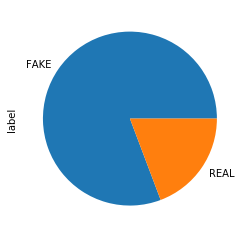

In [11]:
train.groupby("label")["label"].count().plot(kind="pie")

In [12]:
train.groupby("label")["Length"].mean()

label
FAKE    8987.086793
REAL    8986.082081
Name: Length, dtype: float64

In [13]:
train.groupby("label")["Length"].std()

label
FAKE    21.857237
REAL    24.540754
Name: Length, dtype: float64

# Try something stupid!
Stupid in the sense that we'll just try to predict on the metadata. Maybe it works, it probably doesn't. However, let's consider that the mean real video is a bit shorter and the real video length varies a bit more. Nothing significant, but if we don't try we aren't the wiser.

In [14]:
mapper = DataFrameMapper([
     ('label', sklearn.preprocessing.LabelBinarizer()),
     (['Length', 'FPS'], sklearn.preprocessing.StandardScaler()),
     (['Width', 'Height', 'Number Frames'], sklearn.preprocessing.OneHotEncoder())
])

In [15]:
df_["label"] = 0

y, y_val, X, X_val = train_test_split(mapper.fit_transform(train)[:, 0], mapper.transform(train)[:, 1:], test_size=.5, random_state=42)

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [16]:
clf = GradientBoostingClassifier(random_state=42)
clf.fit(X, y)

cross_val_score(clf, X_val, y_val, cv=5)

array([0.82926829, 0.825     , 0.825     , 0.825     , 0.84615385])

In [17]:
clf_dummy = DummyClassifier("prior", random_state=42)
clf_dummy.fit(X, y)

cross_val_score(clf_dummy, X_val, y_val, cv=5)

array([0.82926829, 0.825     , 0.825     , 0.825     , 0.84615385])

Dangit. At least you don't have to try it now.

You made it to the end, so remember that your submission notebooks will be run on the kaggle servers and will count towards your *maximum allowance of 9h*.